# YOLOv3 training based on Repo ultralytics/yolov3

> References:
- https://github.com/ultralytics/yolov3

What I would do in this Jupyter Notebook:
![](./images/yolov3-training.png)

我实现了前两部，但是VSCODE我反复`Ctrl+S`竟然没保存？？？中途Git提交代码了也没有保存进度？？？反正代码很简单，就是将ego-hand训练集前16张图片单独取出来做出新的数据集，也是训练集和验证集，所以data里面train和valid指向一样的txt，names文件都一样。

然后重新设置了两个YOLOv3的model cfg文件（直接从`yolov3-1cls.cfg`修改）：

- `yolov3-hand.cfg`：保证yolo层classes=1，前一个conv层filters=18
- `yolov3-hand-anchors.cfg`：除了上面一个cfg的内容，将yolo层的anchors修改为自己计算的。

另外加上了几句训练的语句，反正本地也没跑出来，明天直接上Colab跑。

这反复保存还没保存一定是bug！还好代码比较简单，这次就不重写了。

## Small dataset: hand64

https://colab.research.google.com/drive/1Oe6opsYZwAhIL04AD4o-OCHo-C2n-M7N?usp=sharing

训练结果

![](https://user-images.githubusercontent.com/45664104/86968130-8f667100-c163-11ea-88d7-f84634e965ba.png)

测试结果
Ground truth
![test_batch0_gt](https://user-images.githubusercontent.com/45664104/87094059-23a10880-c236-11ea-99a3-a42dd1c36cef.jpg)

Prediction
![test_batch0_pred](https://user-images.githubusercontent.com/45664104/87094064-256acc00-c236-11ea-9214-b10315370c0f.jpg)


训练发生了很大的问题：训练效果很差，precisi和recall都是0，mAP保持在0.02以下，所以我现在想看一下是哪里导致了这些问题

- 检查数据集标注有没有问题
- 查看issues看类似问题的思路
- 模型配置文件是不是错了
- 数据集是不是太小了
- 学习速率是不是太小了

### 检查数据集

In [1]:
PATH = '../datasets/hand64'

In [2]:
import sys
sys.path.append('yolov3')

In [3]:
import os
import glob

In [4]:
from utils.utils import plot_one_box, xywh2xyxy

In [5]:
# 检查标注名称和位置是否都正确

# Get all image paths and related annotations

# classes
classes = []
with open(os.path.join(PATH, 'classes.names'), 'r') as f:
    for line in f:
        classes.append(line[:-1])

# image lists
img_paths = []
with open(os.path.join(PATH, 'train.txt'), 'r') as f:
    for line in f:
        img_paths.append(line[:-1])

# annotation lists
anns = []
for img_path in img_paths:
    img_base_name = os.path.basename(img_path)
    ann_path = os.path.join(PATH, 'labels', img_base_name[:-3] + 'txt')
    ann = []
    with open(ann_path, 'r') as f:
        for line in f:
            line = line[:-1]    # Strip '\n'
            line = line.split()
            ann.append(line)
    anns.append(ann)

In [40]:
# Get one sample
image_path = img_paths[0]
ann = anns[0][0]

# attributes
import numpy as np 
import random
import cv2

image = cv2.imread(image_path)
colors = [[random.randint(0, 255) for _ in range(3)] for _ in range(len(classes))]
label = '%s' % (classes[int(ann[0])])
xywh = [float(i) for i in ann[1:]]

xyxy = [0]*4

xyxy[0] = xywh[0] - xywh[2] / 2  # top left x
xyxy[1] = xywh[1] - xywh[3] / 2  # top left y
xyxy[2] = xywh[0] + xywh[2] / 2  # bottom right x
xyxy[3] = xywh[1] + xywh[3] / 2  # bottom right y

In [41]:
xywh

[0.596354, 0.571296, 0.129167, 0.301852]

In [42]:
image.shape

(1080, 1920, 3)

In [43]:
xyxy

[0.5317705, 0.42037, 0.6609375000000001, 0.722222]

In [44]:
xyxy[0] *= image.shape[1]
xyxy[1] *= image.shape[0]
xyxy[2] *= image.shape[1]
xyxy[3] *= image.shape[0]

In [45]:
plot_one_box(xyxy, image, label=label, color=colors[int(ann[0])])
save_path = os.path.join('./images', os.path.basename(image_path)[:-4]+'_write.jpg')
cv2.imwrite(save_path, image)

True

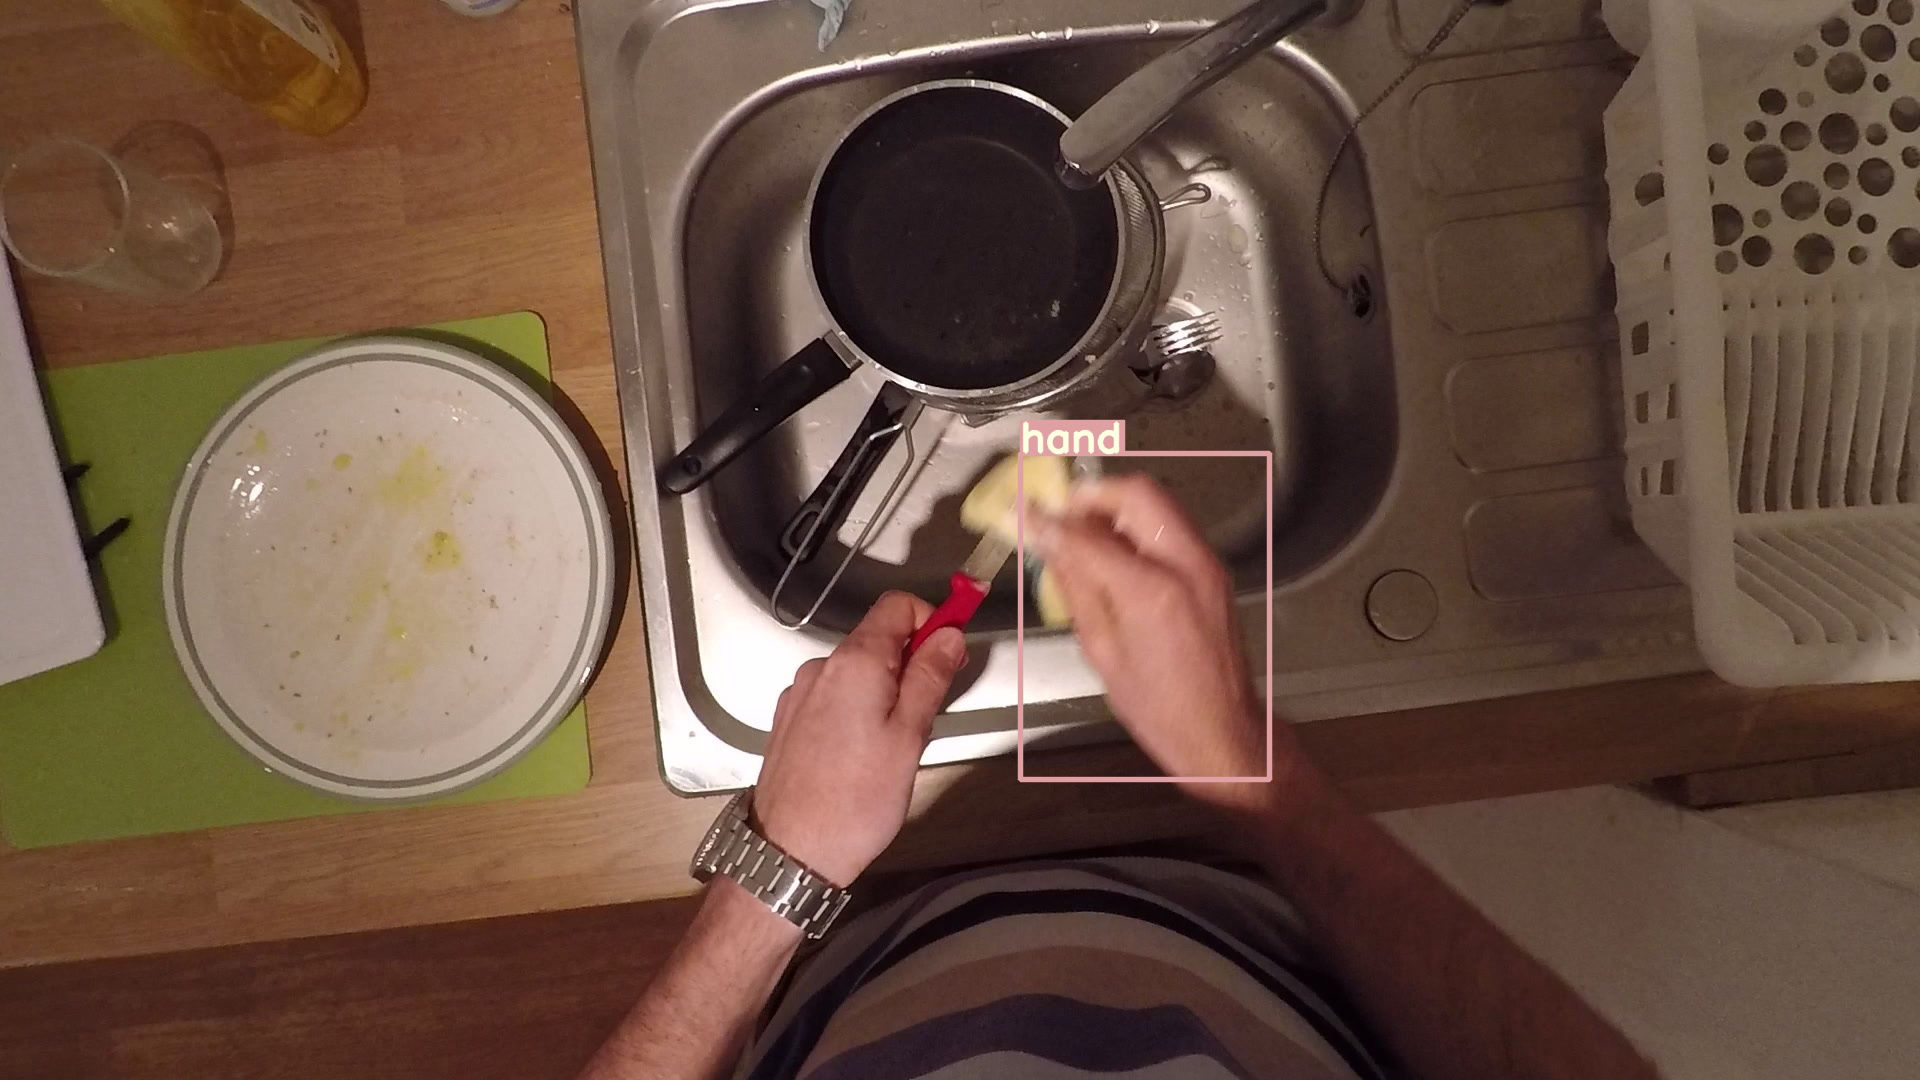

In [46]:
from PIL import Image
im = Image.open(save_path)
im

差得不多，再检查一下标注。

重新自己用一个专门的[yolov3标注工具](https://github.com/developer0hye/Yolo_Label)标注了一张图片，显示标注差不多，说明数据集应该没问题：

![image](https://user-images.githubusercontent.com/45664104/87072216-538ae480-c213-11ea-8479-1df7894840cf.png)


## 检查issues

现在检查一下issue里面有没有提示吧，看前人有没有类似的问题。

https://github.com/ultralytics/yolov3/issues/898#issuecomment-623174650

- 更多图片
- 输入size


先检查一下cfg文件，发现没什么问题，都是按照规范改的。不过试试默认的cfg，
就发现结果更烂，mAP一直为0。
![download](https://user-images.githubusercontent.com/45664104/87096459-cc516700-c23a-11ea-97ff-1dcf5a1f2279.png)


> 为什么看mAP？
https://github.com/ultralytics/yolov3/issues/1252#issuecomment-635795279

然后试试更大的学习速率。在cfg文件里把它改成0.01（原本是0.001）。没有太大改进。

![download (1)](https://user-images.githubusercontent.com/45664104/87098448-379d3800-c23f-11ea-9340-f198b5408667.png)


In [1]:
# 在BlueCrystal Phase 4上训练yolov3模型

In [1]:
# 此处代码均为命令行命令

首先得将anaconda的lib加入DLL环境变量。https://www.jinhang.work/tech/use-uob-supercomputers/#contents:libstdc%E9%97%AE%E9%A2%98

```shell
git clone https://github.com/ultralytics/yolov3
cd yolov3
module add languages/anaconda3/3.7
export LD_LIBRARY_PATH=/mnt/storage/software/languages/anaconda/Anaconda3-2019-3.7/lib:$LD_LIBRARY_PATH
python train.py --cfg ../scratch/ego-hand/yolov3-hand-anchors.cfg --data ../scratch/ego-hand/ego-hand.data --epochs 100 --batch-size 8 --weights '' && mv results.txt results_egohand_egoanc.txt
from utils import utils
utils.plot_results()


```

```
python train.py --cfg ../scratch/ego-hand/yolov3-hand-anchors.cfg --data ../scratch/ego-hand/ego-hand.data --epochs 100 --batch-size 8 --weights weights/last.pt && mv results.txt results_egohand_egoanc.txt

```

目前碰到的困境：拿Colab训练很慢，12小时就没了，100个迭代期只训练到了第19，设置训练完成保存checkpoint也没法保存，只能重新训练，每一个迭代期保存，而且也运用上了之前小数据集训练的checkpoint来resume训练，等待结果中。

以为BC4这个超算会更快吧，现在正在进行每一个迭代期保存checkpoint的训练，但问题是似乎速度很慢，是中间不保存的Colab训练时间的两倍多，最烦的是VPN时效只有12小时，到时候还得重新点一次恢复训练。

这个困境造成的最大问题是：没有前面的算法来产生手的边界框，就很难做接下来的边界框分类任务。但是我思考一点：一定要用自己训练的边界框产生模型来做第一步吗？可以先用训练好的yolo模型来做，得到边界框直接跳到做第二步。

## 使用一个预训练的YOLOv3模型

准备过程
- 训练P30 100迭代期：https://colab.research.google.com/drive/14UP63JCr-JPAjUkcWAdhnjaiTHCmz0vY?usp=sharing
- 在100迭代期基础上恢复训练P30：https://drive.google.com/file/d/148r6qyyvCZKd3nTOZPUivRhYHjh9IkVv/view?usp=sharing
- 在BC4训练ego-hand 100迭代期，每个迭代期保存。

In [1]:
# 首先看看YOLOv3-spp模型
%cd yolov3

f:\PROJECT\project-diary\yolov3


In [ ]:
# 在COCO上训练好的YOLOv3-spp

In [11]:
!python detect.py --source f:\PROJECT\datasets\hand64\images --output ../stage1-output

Namespace(agnostic_nms=False, augment=False, cfg='cfg/yolov3-spp.cfg', classes=None, conf_thres=0.3, device='', fourcc='mp4v', half=False, img_size=512, iou_thres=0.6, names='data/coco.names', output='../stage1-output', save_txt=False, source='f:\\PROJECT\\datasets\\hand64\\images', view_img=False, weights='weights/yolov3-spp-ultralytics.pt')
Using CPU

Model Summary: 225 layers, 6.29987e+07 parameters, 6.29987e+07 gradients
image 1/64 f:\PROJECT\datasets\hand64\images\P01_02_0000006181.jpg: 320x512 1 persons, 1 knifes, Done. (2.015s)
image 2/64 f:\PROJECT\datasets\hand64\images\P01_02_0000006751.jpg: 320x512 2 persons, 1 cups, 1 bowls, Done. (1.878s)
image 3/64 f:\PROJECT\datasets\hand64\images\P01_02_0000011881.jpg: 320x512 1 persons, 2 birds, 1 bottles, Done. (2.307s)
image 4/64 f:\PROJECT\datasets\hand64\images\P01_02_0000012811.jpg: 320x512 1 persons, 1 bottles, Done. (1.815s)
image 5/64 f:\PROJECT\datasets\hand64\images\P01_02_0000022171.jpg: 320x512 1 persons, Done. (2.169s)
ima

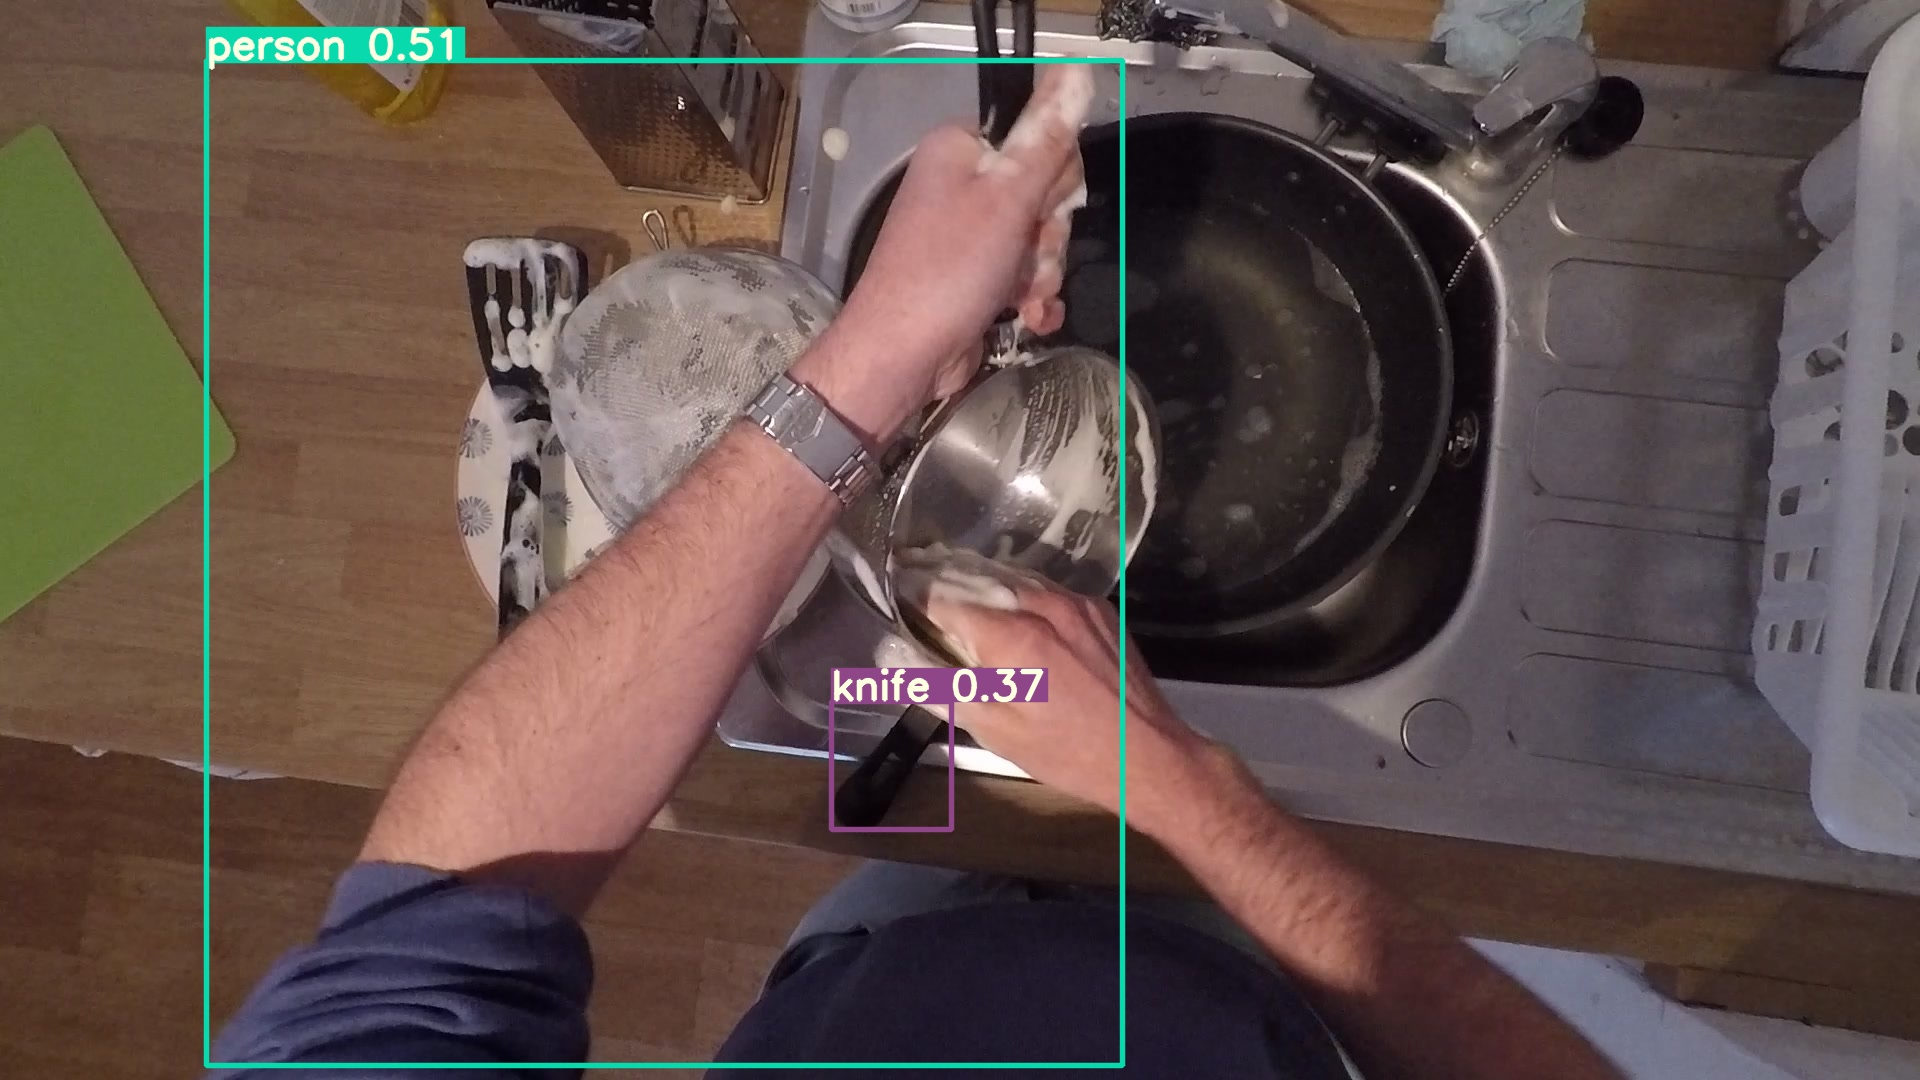

In [13]:
from IPython.display import Image
Image(filename='..\stage1-output\P01_02_0000006181.jpg') 

In [2]:
# 观察到在COCO数据集上训练的yolov3-spp模型很显然不适合提取手的边界框，不过！COCO上训练出来的模型可以输出person包括手臂，如果拿专门的手臂+手数据集是不是更准确呢？不过那是不是很麻烦，手臂加手的数据集直接就可以识别左右手了。

In [3]:
# 在P30数据集上训练的YOLOv3-spp

In [ ]:
# 观察一批图片的检测结果，发现其实差一点的模型在自己的验证集检测结果也不太好，识别常常出错。
# - 检测不出来手的几率比较高
# - 出现两只同样标签的手
# - 左右手标签相反
# 训练结果好点的模型：在验证集表现
# - 检测出手的几率高于weak的
# - 同标签/相反标签几率还是较高，但比weak的低

# 需要更多轮的训练

In [ ]:
# 在ego-hand上训练

In [2]:
!python detect.py --cfg F:\PROJECT\datasets\ego-hand\yolov3-hand-anchors.cfg --names F:\PROJECT\datasets\ego-hand\classes.names --source f:\PROJECT\datasets\hand64\images --output output/yolov3-spp-egohand-epoch4 --weights weights/yolov3-egohand-epoch4.pt

Namespace(agnostic_nms=False, augment=False, cfg='F:\\PROJECT\\datasets\\ego-hand\\yolov3-hand-anchors.cfg', classes=None, conf_thres=0.3, device='', fourcc='mp4v', half=False, img_size=512, iou_thres=0.6, names='F:\\PROJECT\\datasets\\ego-hand\\classes.names', output='output/yolov3-spp-egohand-epoch4', save_txt=False, source='f:\\PROJECT\\datasets\\hand64\\images', view_img=False, weights='weights/yolov3-egohand-epoch4.pt')
Using CPU

Model Summary: 222 layers, 6.15237e+07 parameters, 6.15237e+07 gradients
image 1/64 f:\PROJECT\datasets\hand64\images\P01_02_0000006181.jpg: 320x512 2 hands, Done. (1.837s)
image 2/64 f:\PROJECT\datasets\hand64\images\P01_02_0000006751.jpg: 320x512 1 hands, Done. (1.879s)
image 3/64 f:\PROJECT\datasets\hand64\images\P01_02_0000011881.jpg: 320x512 2 hands, Done. (1.719s)
image 4/64 f:\PROJECT\datasets\hand64\images\P01_02_0000012811.jpg: 320x512 2 hands, Done. (1.921s)
image 5/64 f:\PROJECT\datasets\hand64\images\P01_02_0000022171.jpg: 320x512 2 hands, Do

```shell
Namespace(augment=False, batch_size=16, cfg='../datasets/hand64/yolov3-hand-anchors.cfg', conf_thres=0.001, data='../datasets/ego-hand/ego-hand.data', device='', img_size=416, iou_thres=0.6, save_json=False, single_cls=False, task='test', weights='weights/yolov3-egohand-epoch4.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

Model Summary: 222 layers, 6.15237e+07 parameters, 6.15237e+07 gradients
Fusing layers...
Model Summary: 150 layers, 6.14974e+07 parameters, 6.14974e+07 gradients
Caching labels (3199 found, 0 missing, 0 empty, 0 duplicate, for 3199 images): 100% 3199/3199 [00:05<00:00, 537.20it/s]
               Class    Images   Targets         P         R   mAP@0.5        F1: 100% 200/200 [11:16<00:00,  3.38s/it]
                 all   3.2e+03  4.86e+03     0.782     0.824     0.848     0.802
Speed: 11.1/1.7/12.8 ms inference/NMS/total per 416x416 image at batch-size 16
```

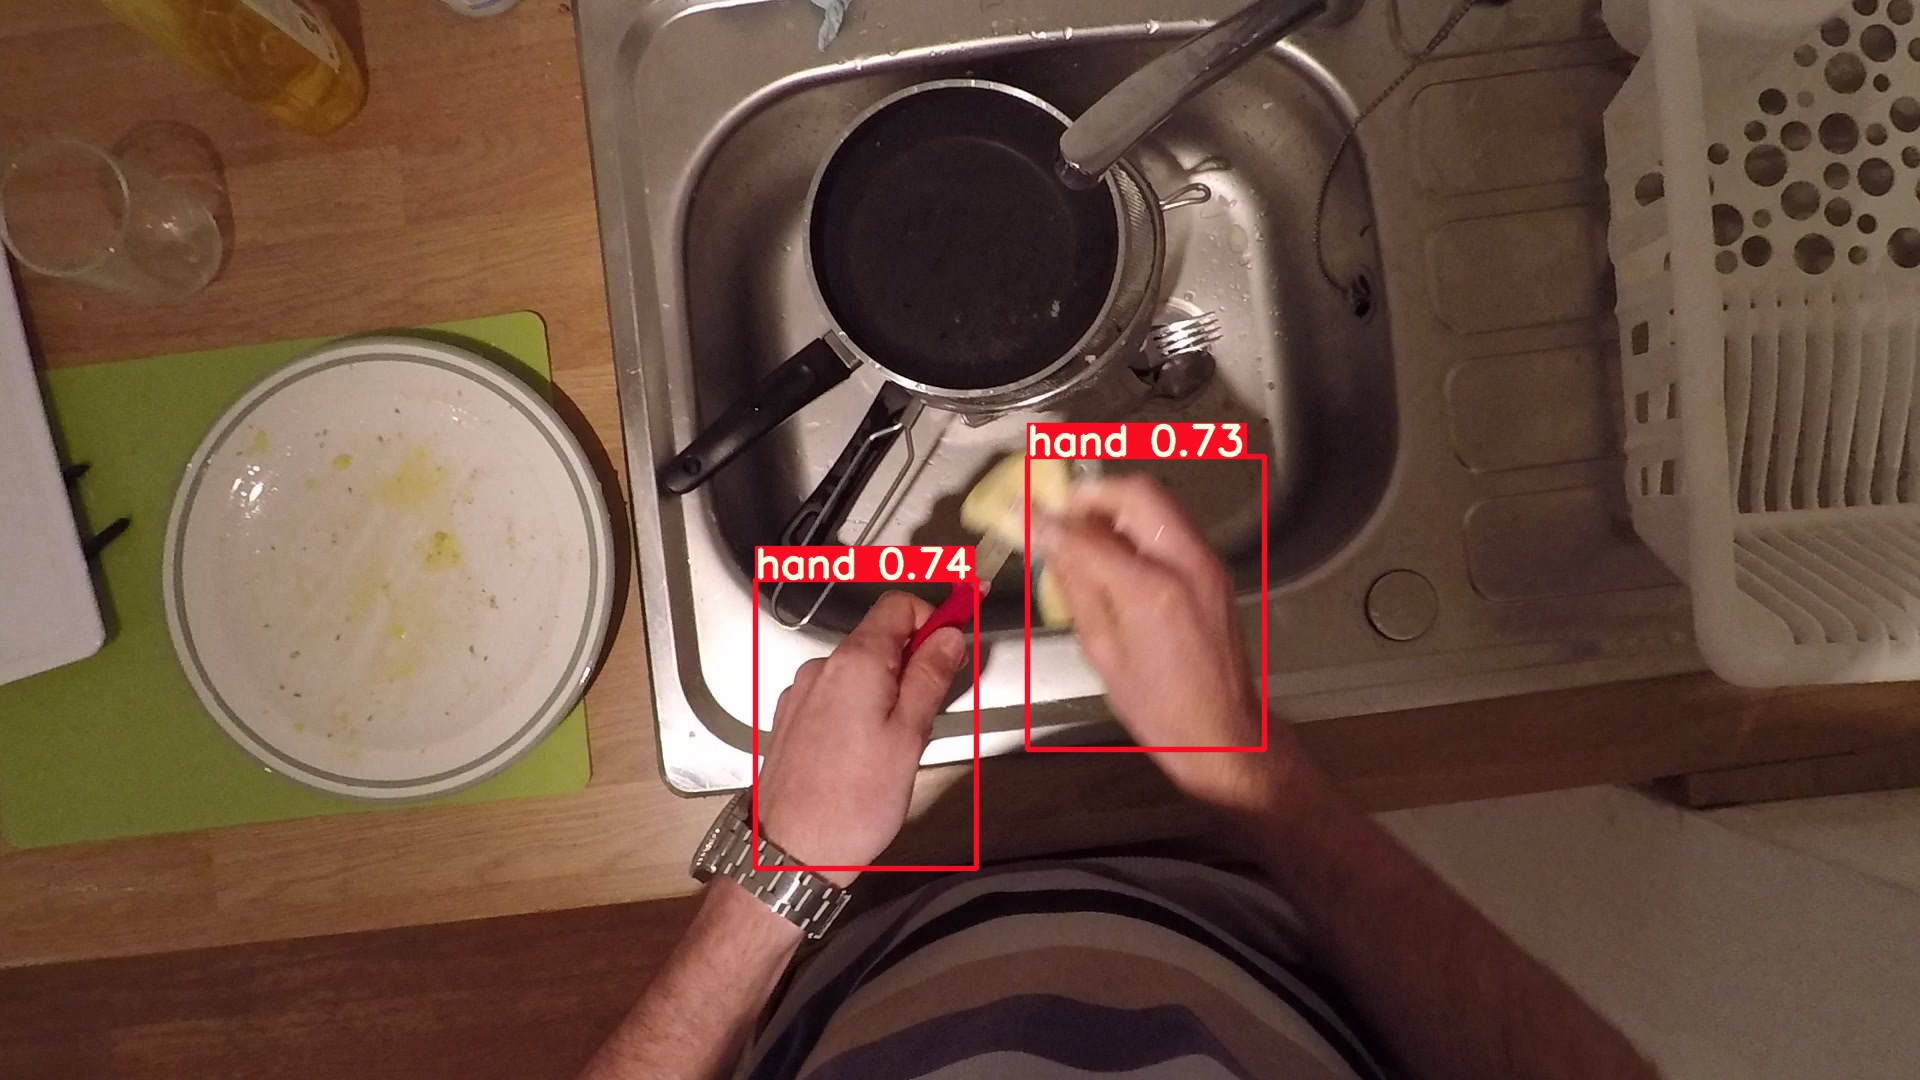

In [4]:
from IPython.display import Image
Image(filename="output/yolov3-spp-egohand-epoch4/P01_06_0000004651.jpg", width=600)

In [1]:
# 可以观察到检测效果也还是不赖的，不过置信度还是不够高，需要更多轮次的训练，现在使用的checkpoint仅仅训练了5个迭代期，不过用来做第二阶段的工具还是OK的。

# 目前来看，egohand的epoch4权重实现的hand检测的mAP为0.848，而P30的100best权重实现的mAP为0.847，后者还在继续训练中，也将会有更好的表现。前者在充分训练后也肯定会更好。目前就采用egohand的权重来做第二阶段任务。后面训练的好就用谁。